# Conserved Motifs Analysis

In [1]:
import os,sys,inspect

path_to_project="/home/martalo/Documentos/TFM/GPCR_variants"
resultspath="/home/martalo/Documentos/TFM/GPCR_variants/Results/studied_GPCR_vars"
dictpath="/home/martalo/Documentos/TFM/GPCR_variants/Results/gpcr_to_pdb/"
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install bioservices
!{sys.executable} -m pip install biopython
!{sys.executable} -m pip install xlrd

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import urllib

import mdtraj as md
import itertools
from htmd.ui import *
from htmd.config import config
config(viewer='webgl')
import requests
import os
from matplotlib.ticker import FormatStrFormatter

!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import csv
import re

import analysis_common_functions as anls

/home/martalo/miniconda3/envs/my_new_env_name/lib/python3.6/site-packages/htmd/versionwarnings.py:29: UserWarning: As of HTMD 1.16 the default ACEMD version for all protocols has changed to version 3. If you want to use version 2 protocols change the _version argument in the protocols or add `config(acemdversion=2)` to the beginning of your scripts. To disable this warning run once: `from htmd import _disableWarnings; _disableWarnings('1.16');`
  , UserWarning)
/home/martalo/miniconda3/envs/my_new_env_name/lib/python3.6/site-packages/htmd/versionwarnings.py:33: UserWarning: As of HTMD 1.16 the default number of threads HTMD spawns for calculations is set to 1. You can enable parallelism at your own risk using `config(njobs=-2)` in the beginning of your scripts. To disable this warning run once: `from htmd import _disableWarnings; _disableWarnings('1.16');`
  , UserWarning)


ffevaluate module is in beta version

Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. https://dx.doi.org/10.1021/acs.jctc.6b00049

HTMD Documentation at: https://www.htmd.org/docs/latest/

New devel HTMD version (1.24.7 python[3.6,<3.7.0a0,3.7,<3.8.0a0]) is available. You are currently on (1.19).There are several methods to update:    - Create a new conda env. using `conda create -n htmd1.24.7 htmd=1.24.7 -c acellera -c psi4 -c conda-forge`    - Create a brand new conda installation and run `conda install htmd -c acellera -c psi4 -c conda-forge`    - Run: `conda update htmd -c acellera -c psi4 -c conda-forge` (NOT RECOMMENDED)



In [2]:
# First read the data file:
# build a data frame
varDataFile="PTM_IMPACT/vars_A_impact_ptm_role4.csv"
df = pd.read_csv(os.path.join(resultspath,varDataFile), delimiter =";") 
print(df.head()) 

   Number               Family                       Subamily  \
0       0  Aminergic receptors  5-Hydroxytryptamine receptors   
1       1  Aminergic receptors  5-Hydroxytryptamine receptors   
2       2  Aminergic receptors  5-Hydroxytryptamine receptors   
3       3  Aminergic receptors  5-Hydroxytryptamine receptors   
4       4  Aminergic receptors  5-Hydroxytryptamine receptors   

                              Name  Short Uniprot ID Uniprot entry  \
0  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
1  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
2  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
3  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
4  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   

                                      Struc             gene         varID  \
0  [Model]: 6G79 (Active) & 4IAQ (Inactive)  ENSG00000178394   rs752821044   
1  [Model]: 6G79 (Active) & 4IAQ

/home/martalo/miniconda3/envs/my_new_env_name/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# y axis, names of the class A receptors. Ex: '5-hydroxytryptamine receptor 1a (HTR1A)'
all_gpcrs_axes_set=set()
long=df['Name'].tolist()
short=df['Short'].tolist()
for l, s in list(zip(long, short)):    
    all_gpcrs_axes_set.add("%s (%s)" % (l,s))
all_gpcrs_axes_list=list(all_gpcrs_axes_set)

# order y-axis by alphabeticall order
all_gpcrs_axes=sorted(all_gpcrs_axes_list, key=str.lower)
print('Total number of GPCRs(rows of heatmap): ',len(all_gpcrs_axes))

Total number of GPCRs(rows of heatmap):  287


## 1. Score analysis
Define the data frame, GPCR in the y axis, positions in the x axis. The colors will be: pale (score 0) for bening MVs, orange (1) for possibly damaging, red (2) damaging, and finally, white (3) for the ones that do not have information.

In [4]:
# x axis, positions of the residues that form the CM 
naBS=['2x50', '3x39', '7x45', '7x46'] # Sodium binding site
ionicLock=['3x50', '6x30'] # Ionic lock
rotTogg=['6x48'] # Rotamer toggle switch
cm_gnum= naBS + ionicLock + rotTogg # all positions in a list
consMotifs = [naBS, ionicLock, rotTogg] # all conserved motifs, list if lists

consMotif = {'naBS':['2x50', '3x39', '7x45', '7x46'], 'ionicLock':['3x50', '6x30'], 'rotTogg':['6x48']} # dictionary

# build a data frame to display the heatmaps
gpcr_cmpos=anls.build_dataFrame(cm_gnum)
# cols are the residues of the binding site of all GPCRs, the rows are the names
# of the class A GPCRs
# initially all the values of the matrix set to 3 (that will correspond to the cells without data)

# Now we have to fill in the df with 0,1,2 depending on the impact score:
# gpcr_bspos[cmpos][gpcrname]= 0,1 or 2
anls.fill_in_dataFrame(gpcr_cmpos, cm_gnum, df)

#display the result as a heatmap
# anls.heatmap_only(gpcr_cmpos)

Now we will add the option of number of variants order and the sum by column and row. First, sum by row, order by number of varinats or not. We will do the separation score 1 and score 2. 

In [5]:
# Sum variants of each GPCR
# Change the number to display the sum of possibly damaging (1) or damaging (2)
# Add 'False' (4th element)  to hide the heatmap, otherwise the barplot will appear below
# Add 'True' (5th element) if you want to order the columns by increasing number of MVs

# anls.heatmap_horizontal_sum(gpcr_cmpos,cm_gnum,2, False)

Now we will put in the same barplot both score 1 and score 2. Without the option to order by incresing number of variants.

ADD THE OPTION TO SORT! If needed, by now is only alphabetically

In [6]:
# Sum variants of each GPCR, barplot below heatmap, with damaging (red) and possibly damaging (orange)
# anls.heatmap_horizontal_sum_mixed(gpcr_cmpos)

In [7]:
# add True as 3rd parameter to display the barplot downwards
# anls.heatmap_vert_sum_mixed(gpcr_cmpos,cm_gnum)

## 2. Disease Analysis

In [8]:
gpcr_cmpos_dis=anls.build_dataFrame(cm_gnum,0)
anls.fill_in_dataFrame_diseases(gpcr_cmpos_dis,cm_gnum,df)
# anls.heatmap_only_diseases(gpcr_cmpos_dis)

+ Variant in MCR1, rs1805006, 2x50: related with 8 diseases, skin hair problems. Tagged as DAMAGING (similar).
+ GNRHR, rs10489383, 6x30: related with 6 diseases, hypogonadism and extrange things. Tagged as DAMAGING (changed).

### 2.1 Diasese heatmap compact

In [9]:
def computeDimensions(listGnum,df,parameter,yaxis=all_gpcrs_axes):
    '''Print GPCRs and Pos that have dis/PTM (depending on the parameter)
    return a list len of GPCRs and len of pos'''
    dim=[]
    gpcrDis=set()
    posDis=set()
    p=re.compile(".*\((\w*)\)")
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            disList=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), parameter].tolist()
            if len(disList)>0:
                if 'Yes' in disList or 'yes' in disList:
                    print(ibspos, gpcr,disList)
                    gpcrDis.add(gpcr)
                    posDis.add(ibspos)
    print('Set of GPCrs and len',gpcrDis,len(gpcrDis))
    print('Set of positions and len',posDis,len(posDis))
    dim.append(len(gpcrDis))
    dim.append(len(posDis))
    return dim

# dimension=computeDimensions(cm_gnum,df,'disease')
dimension=[12, 6]
gpcrsDis=['MC4R', 'EDNRB', 'LHCGR', 'AGTR1', 'AVPR2', 'MC2R', 'GNRHR', 'P2RY12', 'OPN2', 'MC1R', 'PROKR2', 'GALR2']
# posDis=['6x30', '6x48', '2x50', '3x39', '7x46', '3x50']
# posDis.sort()
posDis=['2x50', '3x39', '3x50', '6x30', '6x48', '7x46']
# print(posDis)

In [10]:
def fill_in_dataFrame_diseasesOnly(dataFrame, listGnum, df,disPos,disGpcr,yaxis=all_gpcrs_axes):
    '''Fill in the df with 0,1,2,.. depending on the number of related diseases.
    MAYBE tune with T/F to only the vars with impact score 2'''
    p=re.compile(".*\((\w*)\)")
    difNums=set()
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            if ibspos in disPos and gpcr in disGpcr:
                value=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), 'related_diseases'].tolist()
                disList=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), 'disease'].tolist()
                if len(disList)>0:
                    if 'Yes' in disList or 'yes' in disList:
                        dis='Yes'#Yes/No
                    else:
                        dis='No'
                else:
                    dis='No'
                if len(value)>0:#if there are matches, non-void list   
                    numValues=[x for x in value if x>=0]#avoid NaN
                    if numValues:
                        valueOk=max(numValues)
#                         print(gpcr, ibspos, value, valueOk)
    #                     print('Max value',valueOk)
                if dis=='Yes': 
                    dataFrame[ibspos][gpcr]=valueOk # we will take tha max in case there
                    difNums.add(valueOk)
#                     print(ibspos, gpcrname,dataFrame[ibspos][gpcr])
                    # are two rows matching
                    #  if value equal to NaN, te cell will be zero
    return difNums


disOnly=pd.DataFrame(columns=posDis,index=gpcrsDis).fillna(value=0)
difNumsResDis=fill_in_dataFrame_diseasesOnly(disOnly,cm_gnum,df,posDis,gpcrsDis)
# anls.heatmap_only_diseases(disOnly)

In [11]:
def pos_diseasesOnly(listGnum, df,yaxis=all_gpcrs_axes):
    '''Build list of positions that have related diseases'''
    p=re.compile(".*\((\w*)\)")
    posList=[]
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            disList=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), 'disease'].tolist()
            if len(disList)>0:
                dis=disList[0]#Yes/No
            else:
                dis='Out region'
            if dis=='Yes':                     
                posList.append(ibspos)
#                     print(ibspos, gpcrname,dataFrame[ibspos][gpcr])
                # are two rows matching
                #  if value equal to NaN, te cell will be zero
    return posList


# listPos=pos_diseasesOnly(cm_gnum,df)
# # listPos=['5x461', '7x31', '4x56', '3x37', '5x36', '7x42', '23x49', '2x60', '5x39', '2x53', '3x35', '2x53', '7x31', '3x32', '45x52', '3x28', '5x44', '6x48', '2x53', '23x49', '3x40', '6x52', '2x63', '7x42', '6x44', '5x43', '5x44', '3x25', '3x28', '5x47', '3x29', '2x63', '3x40', '4x56', '4x57', '5x461', '6x59', '2x63', '2x59', '2x63', '45x52', '6x55', '7x41', '7x35', '7x42', '4x57', '6x44', '45x50']
# print(listPos)
# setPos=set()# convert list to set to check how many positions are related with diseases
# for element in listPos:
#     setPos.add(element)
# print(len(listPos), len(setPos))

2021-04-14 12:40:43,238 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


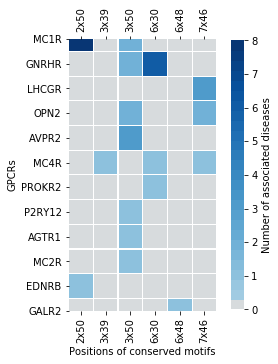

In [12]:
# heatmap and barplots graphs
def heatmap_only_diseases_nonZero(dataFrame,colorPalette='YlOrRd'):
    '''Plot the data frame than contains the color scale for the diseases'''
    color_map_sns=sns.color_palette(colorPalette,n_colors=40).as_hex()
    fig, ax = plt.subplots(figsize=(5,5))
    color_map=color_map_sns[14:]
    color_map.insert(0,'#d7dbdd')
    
    
    ax2=sns.heatmap(dataFrame, cmap=color_map, linewidths=0.1, annot=False, 
        square=True,xticklabels=True, yticklabels=True,ax=ax,cbar=True,cbar_kws={"shrink": .99,'label':'Number of associated diseases'})
    
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
#     ax2.xaxis.set_ticks_position('top')
    
    plt.xticks(rotation=90) 
    
    ax2.set(xlabel='Positions of conserved motifs', ylabel='GPCRs')
    plt.show()
    return None

disOnlyClus=anls.cluster_df(disOnly)#cluster the dataframe
heatmap_only_diseases_nonZero(disOnlyClus,'Blues')
# disease/heatmapOnlyDis.png

In [13]:
# numer of associated diseases of the previous heatmap
difNumsResDis

{1.0, 2.0, 3.0, 6.0, 8.0}

## 3. PTM

In [16]:
gpcr_cmpos_ptm=anls.build_dataFrame(cm_gnum,0) # first all Zeros
# now fill in the df 'gpcr_bspos_ptm' with '1' if there is a 'yes' in the original dataframe
ptmValues=anls.fill_in_dataFrame_ptm(gpcr_cmpos_ptm,cm_gnum,df)
ptmValues

False

No PTMs in the conserved motifs.

## 4. 'Total' analysis (classA): score, disease, PTM
- If score 2: RED -> 2
- If score 1: ORANGE -> 1
- IF score 0: PALE -> 0
- If no-score: WHITE -> 3 
- If score 2 + disease related: color BLUE -> cell 4
- If score 2 + PTM: color PINK -> cell 5
- If score 2 + disease related + PTM: color BLACK -> cell 6

In [17]:
gpcr_cmpos_total=anls.build_dataFrame(cm_gnum,0)
colorsToHeatmap=anls.fill_in_dataFrame_total(gpcr_cmpos_total,gpcr_cmpos,gpcr_cmpos_dis,gpcr_cmpos_ptm,cm_gnum)
# anls.heatmap_only_total(gpcr_cmpos_total, colorsToHeatmap)

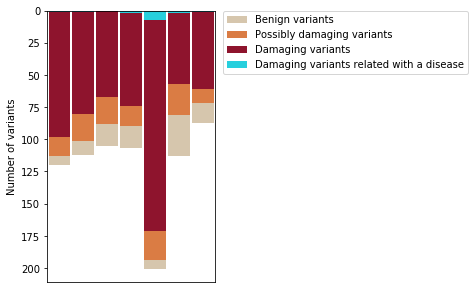

In [18]:
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_cmpos_total,cm_gnum,True,True,False, True, True, 0.9,3 )
# legendOut, downwards, blue, notPink, notBlack
#classA/vertical.png


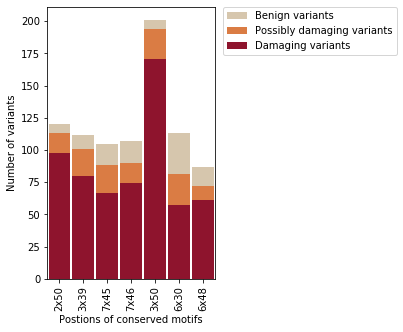

In [20]:
# to put in the part of the 'mapping of dam-pos-ben' as a substitution, take out diseases
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_cmpos_total,cm_gnum,True,False,True, True, True, 0.9,3 )
# legendOut, downwards, blue, notPink, notBlack
#classA/verticalUP.png

## 5. Only aminergic: score, disease, PTM

In [ ]:
families=['5-Hydroxytryptamine receptors', 'Acetylcholine receptors (muscarinic)', 'Adrenoceptors', 'Dopamine receptors', 'Histamine receptors','Trace amine receptor']
aminergicSet=set()
aminergic=[]
aminergicLong=[]

dataFile="myprot_list_struc.csv"
with open(os.path.join(resultspath,dataFile),"r") as myvarfile:
    myvarread = csv.reader(myvarfile, delimiter=';') 
    for myrow in myvarread:
        score=0
        if myrow[0]=='Family':
            continue
        else:
            if myrow[0] in families:
                gpcr=myrow[1]+' ('+myrow[2]+')'
                aminergicSet.add(myrow[2])
                aminergicLong.append(gpcr)
myvarfile.close()    
aminergic=list(aminergicSet)     
# delete the ones without variant info: 
aminergicLong.remove('5-hydroxytryptamine receptor 5B, pseudogene (HTR5BP)')

len(aminergic)
# print(aminergicLong)

In [ ]:
gpcr_cmpos_total_amin=anls.build_dataFrame(cm_gnum,0,aminergicLong)
anls.filter_aminergic(gpcr_cmpos_total,gpcr_cmpos_total_amin,aminergic,cm_gnum)

In [ ]:
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_cmpos_total_amin,cm_gnum,True,True, True, True, True, 0.9,3) # legendOut, downwards, notBlue
#amin/amin_vertical.png, se le tiene que cortar la leyenda

## 5. Clustering
### 5.1 Clustering Class A, heatmap and horizontal sum

In [ ]:
gpcr_cmpos=anls.cluster_df(gpcr_cmpos)
gpcr_cmpos_count=dict(zip(all_gpcrs_axes,[0]*len(all_gpcrs_axes)))
gpcr_cmpos_count_df=pd.DataFrame(list(gpcr_cmpos_count.items()),
                      columns=['GPCR','Count'])
# build dictionaries and df with only damaging:
(gpcr_cmpos_count_damaging_df,df_damaging)=anls.get_count_data(2,gpcr_cmpos)#damaging
# and only possibly damaging and damaging
(gpcr_cmpos_count_all_df,df_all)=anls.get_count_data(1,gpcr_cmpos)# possibly damaging and damaging

sorter=gpcr_cmpos.index
gpcr_cmpos_count_df=anls.order_df_by_sorterlist(sorter,gpcr_cmpos_count_df)
gpcr_cmpos_count_all_df=anls.order_df_by_sorterlist(sorter,gpcr_cmpos_count_all_df)
gpcr_cmpos_count_damaging_df=anls.order_df_by_sorterlist(sorter,gpcr_cmpos_count_damaging_df)

# visualize the clustered heatmap and horizontal barplots without dis, ptm info
# anls.heatmap_only(gpcr_cmpos)
# heatmap_horizontal_sum_mixed_cluster(gpcr_cmpos, gpcr_cmpos_count_all_df,gpcr_cmpos_count_damaging_df )

In [ ]:
# build new dataframe clusterized and with dis/ptm info
gpcr_cmpos_total_clus=pd.DataFrame(index=gpcr_cmpos.index, columns=gpcr_cmpos.columns).fillna(value=0)
colorsToHeatmap=anls.fill_in_dataFrame_total(gpcr_cmpos_total_clus,gpcr_cmpos,gpcr_cmpos_dis,gpcr_cmpos_ptm,cm_gnum)


In [ ]:
anls.heatmap_only_total(gpcr_cmpos_total_clus,'Positions of conserved motifs',"Class A GPCRs", colorsToHeatmap)
# classA/heatmap.png

In [ ]:
# horizontal barplot class A clusterized
def get_counts(dataFrame, varType, yaxes=all_gpcrs_axes):
    ''' Build a dictionary and a data frame with the values that are in the 'range'
    of the corresponding varType, coming from the orignal dataframe'''
    # select the correct scores for each varType
    scores={'benign':[0,1,2,4,5,6],'posDam':[1,2,4,5,6],'dam':[2,4,5,6], 'disPTMjoin':[4,5,6], 'PTMjoin':[5,6], 'join':[6]}
    myList=scores[varType]
    #build dict with values as 0
    gpcr_pos_count_sel=dict(zip(yaxes,[0]*len(yaxes)))
    for gpcridx in gpcr_pos_count_sel.keys():# iterate over the GPCR names
        # count how many times the cells has a valueof the correct list 
        count=len([varval for varval in dataFrame.loc[gpcridx].values if varval in myList])
        gpcr_pos_count_sel[gpcridx]=count
        
    #build new data frame
    gpcr_pos_count_sel_df=pd.DataFrame(list(gpcr_pos_count_sel.items()),
                          columns=['GPCR','Count'])

    df_sel=pd.DataFrame.from_dict(gpcr_pos_count_sel,orient="index").T
    return (gpcr_pos_count_sel_df,df_sel)

def heatmap_total_horizontal_sum_mixed_cluster(dataFrame, small=False, ptm=False, disPTM=False, legendOut=False):
    ''' Build the horizontal barplot, sum for each GPCR, with the disease and PTM info.
    Add True as 2nd parameter if the heatmap will be for only aminergic (smaller df).
    Add True as 3rd parameter if there are ptm values to be displayed (pink).
    Add True as 4th parameter if there are Dis + ptm values to be displayed (black).
    Add True as 5th parameter if you want the legend out of the plot'''
    # build dictionaries and df with only damaging:
    rows=list(dataFrame.index.values)
    (gpcr_ibspos_count_ben_df,df_ben)=get_counts(dataFrame,'benign',rows)#bening
    (gpcr_ibspos_count_damaging_df,df_damaging)=get_counts(dataFrame,'dam',rows)#damaging
    # and only possibly damaging and damaging
    (gpcr_ibspos_count_all_df,df_all)=get_counts(dataFrame,'posDam',rows)# possibly damaging and damaging
    
    # dam+dis
    (gpcr_ibspos_count_dis_df,df_dis)=get_counts(dataFrame,'disPTMjoin',rows)#damaging+disease
    # dam+ptm
    (gpcr_ibspos_count_ptm_df,df_ptm)=get_counts(dataFrame,'PTMjoin',rows)#damaging+ptm
    # dam+dis+ptm
    (gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)=get_counts(dataFrame,'join',rows)#damaging+dis+ptm

    abundance_dist_damaging_df=anls.get_count_dist(gpcr_ibspos_count_damaging_df,df_damaging)
    abundance_dist_all_df=anls.get_count_dist(gpcr_ibspos_count_all_df,df_all)
    abundance_dist_bening_df=anls.get_count_dist(gpcr_ibspos_count_ben_df,df_ben)
    
    abundance_dist_dis_df=anls.get_count_dist(gpcr_ibspos_count_dis_df,df_dis)
    abundance_dist_ptm_df=anls.get_count_dist(gpcr_ibspos_count_ptm_df,df_ptm)
    abundance_dist_dis_ptm_df=anls.get_count_dist(gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)
    
    #reprentation of both dataframes in a barplot
    grid = plt.GridSpec(1, 1)
    if not small:
        fig, ax = plt.subplots(figsize=(4,40))
    else: 
        fig, ax = plt.subplots(figsize=(6,11))
    #benign
    ax1=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_ben_df , x="Count",y="GPCR",color="#DDC8A6",label="Benign variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # pos dam
    ax2=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#F3752B",label="Possibly-damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # dam
    ax3=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_damaging_df , x="Count",y="GPCR",color="#A20021",label="Damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    # dis
    ax4=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_dis_df , x="Count",y="GPCR",color="#09E9FB",label="Damaging variants related with diseases")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    
    # PTM
    if ptm:
        ax5=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_ptm_df , x="Count",y="GPCR",color="#F70F9A",label="Damaging variants at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    # PTM+Dis    
    if disPTM:
        ax6=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_ptm_df , x="Count",y="GPCR",color="#030303",label="Damaging variants disease related at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
#     if legendOut:
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     else:
#         plt.legend()
        
    axB.get_yaxis().set_visible(False) # not visible
    plt.show()
    return None
heatmap_total_horizontal_sum_mixed_cluster(gpcr_cmpos_total_clus,False,False,False,True)#non-small, NO PTMs,no Dis+PTM, legend OUT
# classA/horizontal.png

In [ ]:
# Small part of the heatmap
gpcr_cmpos_total_clus_cut = pd.DataFrame(gpcr_cmpos_total_clus)[8:27].copy(deep=True)

def heatmap_only_total_cut(dataFrame,colors,axisText,x=5,y=5):
    
    '''Plot the data frame than contains the info of the score, diseases and PTM'''    
    colormap=["#DDC8A6","#F3752B","#A20021", "#EDEDF4"] 
    if 'blue' in colors: # there are cells with 10
        colormap.append( "#09E9FB")
    if 'pink' in colors:# there are cells with 20
        colormap.append( "#F70F9A")
    if 'black' in colors: # there are cells with 30
        colormap.append( "#030303")
    print(colormap)
    fig, ax = plt.subplots(figsize=(x,y))
    # bening, poss, dam,nodata, dis,   ptm, dis-ptm
    # 0,      1,     2,    3,    4,   5,      6
    # pale, orange, red, white, blue, pink, black
    ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
    ax2.xaxis.set_ticks_position('top')
    ax.set(xlabel=axisText,ylabel='Class A GPCRs')    
    ax2.xaxis.set_label_position('top')
    plt.xticks(rotation=90)
    return None
    
heatmap_only_total_cut(gpcr_cmpos_total_clus_cut, colorsToHeatmap, 'Positions of conserved motifs',8,8)
# classA/heatmapZoom.png


In [ ]:
def heatmap_total_horizontal_sum_mixed_cluster_cut(dataFrame, x,y, small=False, dis=False, ptm=False, disPTM=False, legendOut=False, yText=False):
    ''' Build the horizontal barplot, sum for each GPCR, with the disease and PTM info.
    Add True as 2nd parameter if the heatmap will be for only aminergic (smaller df).
    Add True as 3rd parameter if there are ptm values to be displayed (pink).
    Add True as 4th parameter if there are Dis + ptm values to be displayed (black).
    Add True as 5th parameter if you want the legend out of the plot
    dd True as 6th parameter if you want to hide the ylabels'''
    # build dictionaries and df with only damaging:
    rows=list(dataFrame.index.values)
    (gpcr_ibspos_count_ben_df,df_ben)=anls.get_counts(dataFrame,'benign',rows)#bening
    (gpcr_ibspos_count_damaging_df,df_damaging)=anls.get_counts(dataFrame,'dam',rows)#damaging
    # and only possibly damaging and damaging
    (gpcr_ibspos_count_all_df,df_all)=anls.get_counts(dataFrame,'posDam',rows)# possibly damaging and damaging
    
    # dam+dis
    (gpcr_ibspos_count_dis_df,df_dis)=anls.get_counts(dataFrame,'disPTMjoin',rows)#damaging+disease
    # dam+ptm
    (gpcr_ibspos_count_ptm_df,df_ptm)=anls.get_counts(dataFrame,'PTMjoin',rows)#damaging+ptm
    # dam+dis+ptm
    (gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)=anls.get_counts(dataFrame,'join',rows)#damaging+dis+ptm

    abundance_dist_damaging_df=anls.get_count_dist(gpcr_ibspos_count_damaging_df,df_damaging)
    abundance_dist_all_df=anls.get_count_dist(gpcr_ibspos_count_all_df,df_all)
    abundance_dist_bening_df=anls.get_count_dist(gpcr_ibspos_count_ben_df,df_ben)
    
    abundance_dist_dis_df=anls.get_count_dist(gpcr_ibspos_count_dis_df,df_dis)
    abundance_dist_ptm_df=anls.get_count_dist(gpcr_ibspos_count_ptm_df,df_ptm)
    abundance_dist_dis_ptm_df=anls.get_count_dist(gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)
    
    #reprentation of both dataframes in a barplot
    grid = plt.GridSpec(1, 1)
    fig, ax = plt.subplots(figsize=(x,y)) 
    #benign
    ax1=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_ben_df , x="Count",y="GPCR",color="#DDC8A6",label="Benign variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    if not yText:
        axB.get_yaxis().set_visible(False) # not visible
        
    # pos dam
    ax2=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#F3752B",label="Possibly-damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # dam
    ax3=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_damaging_df , x="Count",y="GPCR",color="#A20021",label="Damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    # dis
    if dis:
        ax4=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_df , x="Count",y="GPCR",color="#09E9FB",label="Damaging variants related with diseases")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    


    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    return None
heatmap_total_horizontal_sum_mixed_cluster_cut(gpcr_cmpos_total_clus_cut,5,8,True,True,True,True)#non-small, PTMs(pink), PTM+Dis(black), legend out
#classA/horizontalZoom


In [ ]:
heatmap_vert_sum_mixed_total_allColors(gpcr_cmpos_total_clus_cut,cm_gnum,3,True,False) # downwards, notBlue
# classA/verticalZoom


### 5.2  Clustering Aminergic, heatmap and horizontal sum

In [ ]:
gpcr_cmpos_total_amin=anls.cluster_df(gpcr_cmpos_total_amin)#cluster the dataframe

rows=list(gpcr_cmpos_total_amin.index.values)
gpcr_cmpos_count_amin=dict(zip(aminergicLong,[0]*len(aminergicLong)))
gpcr_cmpos_count_amin_df=pd.DataFrame(list(gpcr_cmpos_count_amin.items()),
                      columns=['GPCR','Count'])

def heatmap_only_total_CM(dataFrame,axisText,x=40,y=40):
    '''Plot the data frame than contains the info of the score, diseases and PTM, special for 
    CM aminergic: no 0 nor 4,5,6'''    
    colormap=["#F3752B","#A20021", "#EDEDF4"]
    fig, ax = plt.subplots(figsize=(x,y))
    # bening, poss, dam,nodata, dis,   ptm, dis-ptm
    # 0,      1,     2,    3,    4,   5,      6
    # pale, orange, red, white, blue, pink, black
    ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
    ax2.xaxis.set_ticks_position('top')
    ax.set(xlabel=axisText,ylabel='Aminergic GPCRs') 
    ax2.xaxis.set_label_position('top')
    plt.xticks(rotation=90) 
    plt.show()
    return None
heatmap_only_total_CM(gpcr_cmpos_total_amin,'Positions of conserved motifs',10,11)

#amin/amin_heatmap.png

In [ ]:
# horizontal barplot
heatmap_total_horizontal_sum_mixed_cluster_cut(gpcr_cmpos_total_amin,3,9,True,False,True,True)#non-small, PTMs(pink), PTM+Dis(black), legend out
#amin/amin_horizontal.png

# Mapping
Now we will map in a template, an aminergic GPCR, the variants colored by frequency.
+ Positions 'more porbably damaged when mutated' with more score '2' (and '1'). 
+ Positions 'more ralated with diseases', colored by number of related diseases/number of different variants.
+ Positions related with PTMs (none in this region).
+ Positions 'more interesting positions', the ones that have score 2 and are related with diseases/PTMs, for class A and aminergic.

In [ ]:
# en esta region yo no podria los scores sino una imagen con las posiciones en diferente color


def min_max_freqs_percentage(freqMin, freqMax):
    '''Compute the min and max frequencies in % in a list, min and max'''
    values=[]
    values.append(freqMin*100/len(all_gpcrs_axes))
    values.append(freqMax*100/len(all_gpcrs_axes))
    return values

def create_reps_colormap(gpcr,pdbName,pdbPath,vars_display,colorPalette='YlOrRd',rep_chains=False):
    ''' Configuration of a view of a GPCR with its varints of the BS in VDW representantion and
    color depending on the number of times the variants appear in that position for all the GPCRs.
    norm is used to spread the freq values for all the 61 colors, otherwise not all the color scale
    may be reached'''
     
    pdb=pdbName
    affected_vars=[]
    unaffected_vars=[]
    unknown_vars=[]
    rep_chains=set()
        
    color_dic={}
    freq_set=set()
    for element in vars_display:
        freq_set.add(element['value'])
    freq_unique_sorted=list(freq_set)
    freq_unique_sorted.sort()
    norm_colors=[]
    
    if colorPalette=='Blues':
        color_map_long=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)+10).as_hex()
        color_map=color_map_long[10:]
        color_map.insert(0,'#ffffff')
    elif colorPalette=='RdPu': 
        color_map=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)).as_hex()
        color_map.insert(0,'#ffffff')
    else:
        color_map=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)).as_hex()
    print('Frequencies:',freq_unique_sorted)
#     print(color_map)
    print('The min and max values of the frequencies in percentage:')
    print(min_max_freqs_percentage(freq_unique_sorted[0],freq_unique_sorted[-1]))#min and max in %
    
    for i in range(0,len(freq_unique_sorted)):# build dictionary frequency:color
        color_dic[freq_unique_sorted[i]]=color_map[i]    
    
    if rep_chains: 
        gpcr_sel="protein and (%s)" % " or ".join(rep_chains)
    else:
        gpcr_sel="protein and chain A and resid < 1000"
    mypdb=pdb+".pdb"
    mypdbpath=os.path.join(pdbPath,mypdb)
    mol = Molecule(mypdbpath)
    mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='NewCartoon')
#     mol.reps.add(sel=gpcr_sel,style='VDW')

    for var in vars_display:
#         print(var['value'], color_dic[var['value']])
        mysel="(name CA and resid "+var["pdb_pos"]+" and chain "+var["chain"]+")"
        mol.reps.add(sel=mysel ,color=color_dic[var['value']],style='VDW')
    mol.center()
    mol.camera = 'orthographic'
    return mol

### 1. Positions more porbably damaged when mutated

In [ ]:
# return a dictionary with the position and frequency: score_freq_dict
# score 2:
score_freq_dict=anls.freq_score_dic(gpcr_cmpos,cm_gnum,2)
# score 1:
score_freq_dict_1=anls.freq_score_dic(gpcr_cmpos,cm_gnum,1)
# score 0:
score_freq_dict_0=anls.freq_score_dic(gpcr_cmpos,cm_gnum,0)
# score 3:
score_freq_dict_3=anls.freq_score_dic(gpcr_cmpos,cm_gnum,3)

# % of cells in the heatmap that have score 2:
anls.percentage_cells(all_gpcrs_axes,score_freq_dict,2)
#score 1:
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_1,1)
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_0,0)
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_3,3)

The number of cells is the number of GPCRs (rows, in this case class A) multiplied by the number of positions that form the CMs.

In [ ]:
gpcr="HTR2A" # Template, 5-hydroxytryptamine receptor 2A, drug target, aminergic
pdbname="6A94" # inactive structure
pdb_path=os.path.join(path_to_project,"Data/pdb_files/")
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdb=anls.gpcr_pdb_dict_fom_json(dictpath+json_filename)


# score 2
vars_display=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict.items():
    score_var_info={}
    if gnum in gpcr_pdb:
        score_var_info["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info["value"]=freq
        vars_display.append(score_var_info)
# vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display,'Reds')
# vieww.camera = 'orthographic'
# vieww.view()

In [ ]:
# score 1
vars_display_1=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict_1.items():
    score_var_info_1={}
    if gnum in gpcr_pdb:
        score_var_info_1["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_1["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_1["value"]=freq
        vars_display_1.append(score_var_info_1)
# vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_1,'Reds')
# vieww.camera = 'orthographic'
# vieww.view()

In [ ]:
# score 0
vars_display_0=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict_0.items():
    score_var_info_0={}
    if gnum in gpcr_pdb:
        score_var_info_0["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_0["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_0["value"]=freq
        vars_display_0.append(score_var_info_1)
# vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_0,'Reds')
# vieww.camera = 'orthographic'
# vieww.view()

### 2. Positions more ralated with diseases
#### 2.1 Colored by number of related diseases

In [ ]:
relDiseases_freq_dict=anls.freq_disease_dic(gpcr_cmpos_dis, cm_gnum)

In [ ]:
# Related diseases of variants in each position
vars_display_relDis=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in relDiseases_freq_dict.items():
    score_var_info_relDis={}
    if gnum in gpcr_pdb:
        score_var_info_relDis["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_relDis["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_relDis["value"]=freq
        vars_display_relDis.append(score_var_info_relDis)
vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_relDis,'Blues')
vieww.camera = 'orthographic'
vieww.view()
# maybe this image attached to the heatmapOnlyDis??
# 6/7 positions of the CMs are related with diseases (1 as min, 12 as max)

#### 2.2 Colored by number of different variants
In here we will just consider the variants related with diseases that are also score 2.

In [ ]:
disDamaging_freq_dict=anls.freq_score_dic(gpcr_cmpos_total_clus,cm_gnum,4)
# disDamaging_freq_dict
anls.percentage_cells(all_gpcrs_axes,disDamaging_freq_dict,4)

In [ ]:
# score 4, dis+damaging
vars_display_dis=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in disDamaging_freq_dict.items():
    score_var_info_dis={}
    if gnum in gpcr_pdb:
        score_var_info_dis["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_dis["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_dis["value"]=freq
        vars_display_dis.append(score_var_info_dis)
create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_dis).view()

### 2.3 Variants affecting PTMs
There are not PTMs in the intracellular regions.

### 4. Positions 'more interesting' to simulate 
The ones that have score 2 and are related with diseases/PTMs in the aminergic family. As there is no variant  here realted with diseases or PTM, we look to the barplots. We see that the most interesting possition is the ionic lock, the one that is more time variated and with score 2. The GPCR with more variants (including 3x50) is the HTR1B. But we could choose another one that is an interesting drug target. 

In [ ]:
anls.heatmap_vert_sum_mixed(gpcr_cmpos,cm_gnum)

In [ ]:
gpcr="HTR2B" # 5-hydroxytryptamine receptor 2B
pdbname="5TUD" # inactive structure
pdb_path=os.path.join(path_to_project,"Data/pdb_files/")
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdb=anls.gpcr_pdb_dict_fom_json(dictpath+json_filename)

gnum='3x50'
if gnum in gpcr_pdb:
    pdb_pos=gpcr_pdb[gnum]["pos"]#pdb coordinates
    chain=gpcr_pdb[gnum]["chain"]#chain

mol = Molecule(pdb_filepath)
gpcr_sel="protein and chain D"
mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='NewCartoon') # GPCR (no lig) in white newcartoon
# interesting position
mysel="(name CA and resid "+pdb_pos+" and chain "+chain+")"
mol.reps.add(sel=mysel ,color="#3875B1",style='VDW')

mol.view()

In [ ]:
totalDis=0
for key, value in relDiseases_freq_dict.items():
    totalDis+=relDiseases_freq_dict[key]
print('Total diseases',totalDis)

totalDisDam=0
for key, value in disDamaging_freq_dict.items():
    totalDisDam+=disDamaging_freq_dict[key]
print('Total diseases damaging',totalDisDam)

We could say that this is the more sensitive region, none bening variants, and high population of damaging variants in each position which is consistent with the fact that those are conserved positions. We should choose some of those positions that are variants in a GPCR mental illness drug target.